<a href="https://colab.research.google.com/github/sanggusti/30-days-kaggle/blob/main/colabs/Data_Processing_Using_Parallel_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Data Processing Using Parallel Computing***

#### [Step 7](https://docs.activeloop.ai/getting-started/parallel-computing) in the [Getting Started Guide](https://docs.activeloop.ai/getting-started) highlights how `hub.compute` can be used to rapidly upload datasets. This tutorial expands further and highlights the power of parallel computing for dataset processing.

## Install Hub

In [1]:
from IPython.display import clear_output
!pip3 install hub
clear_output()

In [ ]:
# IMPORTANT - Please restart your Colab runtime after installing Hub!
# This is a Colab-specific issue that prevents PIL from working properly.
import os
os.kill(os.getpid(), 9)

## Dataset Transformations

Computer vision applications often require users to process and transform their data as part of their workflows. For example, you may perform perspective transforms, resize images, adjust their coloring, or many others. In this example, a flipped version of the MNIST dataset is created, which may be useful for training a model that identifies text from reflections in a mirror.

The first step to creating a flipped version of the MNIST dataset is to define a function that will flip the dataset images.

In [1]:
import hub
from PIL import Image
import numpy as np

@hub.compute
def flip_horizontal(sample_in, sample_out):
    ## First two arguments are always default arguments containing:
    #     1st argument is an element of the input iterable (list, dataset, array,...)
    #     2nd argument is a dataset sample
    
    # Append the label and image to the output sample
    sample_out.labels.append(sample_in.labels.numpy())
    sample_out.images.append(np.flip(sample_in.images.numpy(), axis = 1))
    
    return sample_out

Next, the existing MNIST dataset is loaded, and `hub.like` is used to create an empty dataset with the same tensor structure.

In [2]:
ds_mnist = hub.load('hub://activeloop/mnist-train')

#We use the overwrite=True to make this code re-runnable
ds_mnist_flipped = hub.like('./mnist_flipped', ds_mnist, overwrite = True)

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/mnist-train loaded successfully.


Finally, the flipping operation is evaluated for the 1st 100 elements in the input dataset `ds_mnist`, and the result is automatically stored in `ds_mnist_flipped`.

In [3]:
flip_horizontal().eval(ds_mnist[0:100], ds_mnist_flipped, num_workers = 2)

Evaluating flip_horizontal: 100%|██████████| 100/100 [00:02<00:00, 49.90it/s]


Let's check out the flipped images:

In [4]:
Image.fromarray(ds_mnist.images[0].numpy())

In [5]:
Image.fromarray(ds_mnist_flipped.images[0].numpy())

##Dataset Processing Pipelines

In order to modularize your dataset processing, it is often helpful to create functions for specific data processing tasks, and combine them in pipelines in order to transform your data end-to-end. In this example, you can create a pipeline using the `flip_horizontal` function above and the `resize` function below.

In [6]:
@hub.compute
def resize(sample_in, sample_out, new_size):
    ## First two arguments are always default arguments containing:
    #     1st argument is an element of the input iterable (list, dataset, array,...)
    #     2nd argument is a dataset sample
    ## Third argument is the required size for the output images
    
    # Append the label and image to the output sample
    sample_out.labels.append(sample_in.labels.numpy())
    sample_out.images.append(np.array(Image.fromarray(sample_in.images.numpy()).resize(new_size)))
    
    return sample_out

Functions decorated using `hub.compute` can be easily combined into pipelines using hub.compose. Required arguments for the functions must be passed into the pipeline in this step:

In [7]:
pipeline = hub.compose([flip_horizontal(), resize(new_size = (64,64))])

Just like for the single-function example above, the input and output datasets are created first, and the pipeline is evaluated for the 1st 100 elements in the input dataset `ds_mnist_flipped`. The result is automatically stored in `ds_mnist_pipe`.

In [8]:
#We use the overwrite=True to make this code re-runnable
ds_mnist_pipe = hub.like('./mnist_pipeline', ds_mnist, overwrite = True)

In [9]:
pipeline.eval(ds_mnist[0:100], ds_mnist_pipe, num_workers = 2)

Evaluating [flip_horizontal, resize]: 100%|██████████| 100/100 [00:02<00:00, 49.90it/s]


Let's check out the processed images:

In [10]:
Image.fromarray(ds_mnist.images[0].numpy())

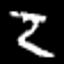

In [11]:
Image.fromarray(ds_mnist_pipe.images[0].numpy())